In [13]:
!pip install imitation

c:\Users\emman\Desktop\PROYECTOS_VS_CODE\PRUEBAS_DE_PYTHON\PORTFOLIO-venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\emman\.cache\huggingface\hub\models--sb3--ppo-CartPole-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Loaded HF expert: sb3/ppo-CartPole-v1
Expert reward: 500.0 ± 0.0
Expert reward: 500.0 ± 0.0
Collected 50 trajectories; flattened to 25000 transitions.
Collected 50 trajectories; flattened to 25000 transitions.
Reward before BC:  223.2
Reward before BC:  223.2


0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.692     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


491batch [00:00, 665.88batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000288 |
|    entropy        | 0.288     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 99.6      |
|    loss           | 0.279     |
|    neglogp        | 0.279     |
|    prob_true_act  | 0.809     |
|    samples_so_far | 16032     |
---------------------------------


781batch [00:01, 661.20batch/s]



Reward after BC:   500.0


Captured 500 frames @ ~50 FPS
MP4 final size: 0.03 MB
MP4 final size: 0.03 MB
GIF attempts (fps, frames_kept, size_MB):
  - 50 fps |  500 frames |   0.12 MB
GIF final size: 0.12 MB
GIF attempts (fps, frames_kept, size_MB):
  - 50 fps |  500 frames |   0.12 MB
GIF final size: 0.12 MB


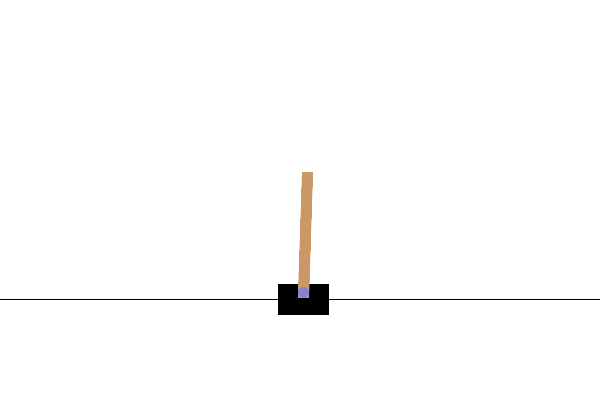

Saved: cartpole-v1_bc.mp4 cartpole-v1_bc.gif


In [14]:
# IMITATION LEARNING on Acrobot-v1 (non-Box2D) + MP4/GIF recording ≤100MB
# Works in notebooks or as a .py script.

# --- (A) Deps, installs, and compatibility patches ---
import importlib, sys, subprocess, os, math, base64

def ensure(spec, import_name=None):
    try:
        importlib.import_module(import_name or spec.split("[")[0])
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", spec])

# Core libs & extras
ensure("imitation")
ensure("stable-baselines3", "stable_baselines3")
ensure("torch")                       # SB3 needs torch available
ensure("gymnasium[classic-control]", "gymnasium")
ensure("gym==0.26.2", "gym")          # for HF model unpickling (older SB3 models)
ensure("pygame")                      # needed for classic_control rgb_array rendering
ensure("imageio")
ensure("imageio-ffmpeg", "imageio_ffmpeg")
ensure("huggingface_hub")
ensure("cloudpickle")

import numpy as np
# NumPy 2.0 shims for older code paths
if not hasattr(np, "float_"): np.float_ = np.float64
if not hasattr(np, "int"):    np.int    = np.int64
if not hasattr(np, "bool"):   np.bool   = np.bool_

import gymnasium as gym
from IPython.display import HTML, display, Image as IPyImage
import imageio.v2 as imageio

from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
from imitation.algorithms import bc

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO

# --- (B) Env setup (pick any NON-Box2D env) ---
# Examples: "Acrobot-v1", "Pendulum-v1", "MountainCar-v0", "FrozenLake-v1" (use pixel wrapper if needed)
ENV_ID = "CartPole-v1"
SEED = 42

env = make_vec_env(
    ENV_ID,
    n_envs=1,
    rng=np.random.default_rng(SEED),
    post_wrappers=[lambda e, _: RolloutInfoWrapper(e)],
)

# --- (C) Expert loading (Hugging Face) with PPO fallback training ---
def load_or_train_expert(venv):
    try:
        expert = load_policy(
            "ppo-huggingface",     # uses HF Hub (RL Zoo format)
            organization="sb3",     # e.g., sb3/ppo-Acrobot-v1
            env_name=ENV_ID,
            venv=venv,
        )
        print(f"Loaded HF expert: sb3/ppo-{ENV_ID}")
        return expert
    except Exception as e:
        print(f"HF load failed ({repr(e)}). Training a small PPO expert as fallback...")
        expert = PPO(
            policy="MlpPolicy",
            env=venv,
            seed=SEED,
            batch_size=64,
            ent_coef=0.0,
            learning_rate=3e-4,
            n_epochs=10,
            n_steps=64,
            verbose=0,
        )
        expert.learn(200_000)  # increase to 200k+ for stronger expert
        return expert

expert = load_or_train_expert(env)

# Quick sanity check
mean_r, std_r = evaluate_policy(expert, env, n_eval_episodes=10)
print(f"Expert reward: {mean_r:.1f} ± {std_r:.1f}")

# --- (D) Collect expert demonstrations ---
rng = np.random.default_rng(SEED)
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)
print(f"Collected {len(rollouts)} trajectories; flattened to {len(transitions)} transitions.")

# --- (E) Behavior Cloning ---
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
)

r_before, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward before BC:  {r_before:.1f}")

bc_trainer.train(n_epochs=1)  # raise epochs for better cloning
r_after, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward after BC:   {r_after:.1f}")

# --- (F) Record cloned policy to MP4 + GIF (≤100 MB) ---
render_env = gym.make(ENV_ID, render_mode="rgb_array")
fps = int(render_env.metadata.get("render_fps", 30))
obs, info = render_env.reset(seed=SEED)

frames = []
done = False
max_frames = 6000  # cap to avoid huge files

while not done and len(frames) < max_frames:
    action, _ = bc_trainer.policy.predict(obs, deterministic=True)
    # discrete env guard: convert array([a]) -> int
    if isinstance(action, np.ndarray) and action.shape == (1,):
        action = int(action.item())
    obs, reward, terminated, truncated, info = render_env.step(action)
    frame = render_env.render()  # (H, W, 3) uint8
    frames.append(frame)
    done = bool(terminated or truncated)
render_env.close()

print(f"Captured {len(frames)} frames @ ~{fps} FPS")

# Writers and size guard
MP4_PATH = f"{ENV_ID.replace('/', '_').lower()}_bc.mp4"
GIF_PATH = f"{ENV_ID.replace('/', '_').lower()}_bc.gif"
MAX_MB = 100
MIN_FPS = 3

def file_mb(path: str) -> float:
    return os.path.getsize(path) / (1024 * 1024) if os.path.exists(path) else 0.0

def write_mp4(frames, fps, path):
    w = imageio.get_writer(path, format="mp4", fps=fps)  # requires imageio-ffmpeg
    for f in frames:
        w.append_data(f)
    w.close()

def fit_under_cap_by_fps(frames, orig_fps, writer_fn, out_path, max_mb=100, min_fps=3, step=5, is_gif=False):
    """
    Lower effective FPS (not frame count) until file size <= max_mb.
    For MP4, keep all frames and only reduce fps.
    For GIF, drop frames if needed.
    """
    attempts = []
    schedule = list(range(int(orig_fps), min_fps - 1, -step))
    if schedule[-1] != min_fps:
        schedule.append(min_fps)
    for target_fps in schedule:
        if is_gif:
            stride = max(1, math.ceil(orig_fps / max(1, target_fps)))
            sub = frames[::stride]
            imageio.mimsave(out_path, sub, format="gif", duration=1.0 / float(max(1, target_fps)))
        else:
            # For MP4, keep all frames, just lower fps
            writer_fn(frames, target_fps, out_path)
        size = file_mb(out_path)
        attempts.append((target_fps, len(frames if not is_gif else sub), size))
        if size <= max_mb:
            return True, attempts
    return False, attempts

# MP4
write_mp4(frames, fps, MP4_PATH)
if file_mb(MP4_PATH) > MAX_MB:
    ok, attempts = fit_under_cap_by_fps(frames, fps, write_mp4, MP4_PATH, MAX_MB, MIN_FPS, is_gif=False)
    print("MP4 attempts (fps, frames_kept, size_MB):")
    for a in attempts:
        print(f"  - {a[0]:>2} fps | {a[1]:>4} frames | {a[2]:6.2f} MB")
print(f"MP4 final size: {file_mb(MP4_PATH):.2f} MB")

# GIF
ok, attempts = fit_under_cap_by_fps(frames, fps, None, GIF_PATH, MAX_MB, MIN_FPS, is_gif=True)
print("GIF attempts (fps, frames_kept, size_MB):")
for a in attempts:
    print(f"  - {a[0]:>2} fps | {a[1]:>4} frames | {a[2]:6.2f} MB")
print(f"GIF final size: {file_mb(GIF_PATH):.2f} MB")

# --- (G) Inline preview (if in notebook) ---
try:
    with open(MP4_PATH, "rb") as f:
        mp4_b64 = base64.b64encode(f.read()).decode("ascii")
    display(HTML(f"""
    <video width="480" controls>
      <source src="data:video/mp4;base64,{mp4_b64}" type="video/mp4">
    </video>
    """))

    with open(GIF_PATH, "rb") as f:
        gif_bytes = f.read()
    display(IPyImage(data=gif_bytes))
except Exception as _e:
    # Safe to ignore if running as .py or outside Jupyter
    pass

print("Saved:", MP4_PATH, GIF_PATH)
